**PENGUMPULAN DATA**


Mengunggah file data.zip ke instance Google Colab dengan mengeklik ikon "File" di sisi kiri browser, lalu ikon "Unggah ke penyimpanan sesi". Pilih folder zip untuk mengunggahnya.

In [1]:
!nvidia-smi

Sun Jun 22 17:48:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Menampilkan informasi GPU NVIDIA yang tersedia di sistem. Ini sangat berguna terutama saat kita menjalankan pelatihan model (YOLO) untuk memastikan GPU aktif dan siap digunakan.

##Split images into train and validation folders

Melakukan aksi unzip data.zip untuk mengekstrak dataset ZIP ke dalam folder khusus (custom_data) agar dapat digunakan dalam pelatihan YOLO.

In [2]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [3]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-06-22 17:48:12--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-06-22 17:48:13 (59.7 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 128
Number of annotation files: 128
Images moving to train: 115
Images moving to validation: 13


Kodingan diatas digunakan untuk memisahkan data gambar ke dalam set pelatihan dan validasi (train/val split). Kemudian menunjukkan lokasi folder asal yang berisi seluruh data (biasanya hanya 1 folder berisi gambar dan label) dan menyuruh skrip untuk membagi 90% data ke folder train dan 10% ke folder val (validasi).

**Install Requirements (Ultralytics)**

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

**CONFIGURE TRAINING**

In [5]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 14
names:
- Beryl's Almond Dark
- Beryl's Almond Milk
- Beryl's Mint & Bitter
- Chacha
- Fitbar
- Happydent
- Himalaya Vajomba
- Kacang Pukul
- Milkita Bites
- Milo
- SilverQueen
- Snickers
- Xylitol
- Yupi


**TRAIN MODEL - Run Training**

In [7]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

**TEST MODEL**

In [8]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,418,218 parameters, 0 gradients, 21.3 GFLOPs

image 1/13 /content/data/validation/images/2f7ebd66-IMG-20250621-WA0106.jpg: 640x640 1 Chacha, 1 Milo, 1 SilverQueen, 1 Snickers, 15.7ms
image 2/13 /content/data/validation/images/60595822-IMG-20250621-WA0077.jpg: 640x480 1 Himalaya Vajomba, 1 Xylitol, 49.0ms
image 3/13 /content/data/validation/images/66ad6f41-IMG-20250621-WA0028.jpg: 640x480 1 Beryl's Almond Dark, 12.3ms
image 4/13 /content/data/validation/images/7598ff72-WhatsApp_Image_2025-06-20_at_20.01.39_4516c81d.jpg: 640x480 1 Beryl's Mint & Bitter, 12.5ms
image 5/13 /content/data/validation/images/82e04e76-IMG-20250621-WA0074.jpg: 640x480 1 Chacha, 1 Fitbar, 1 Happydent, 1 Himalaya Vajomba, 1 Kacang Pukul, 1 Milkita Bites, 1 SilverQueen, 1 Xylitol, 1 Yupi, 12.4ms
image 6/13 /content/data/validation/images/8799b7ee-IMG-20250621-WA0133.jpg: 640x480 1 Chacha, 1 Milo

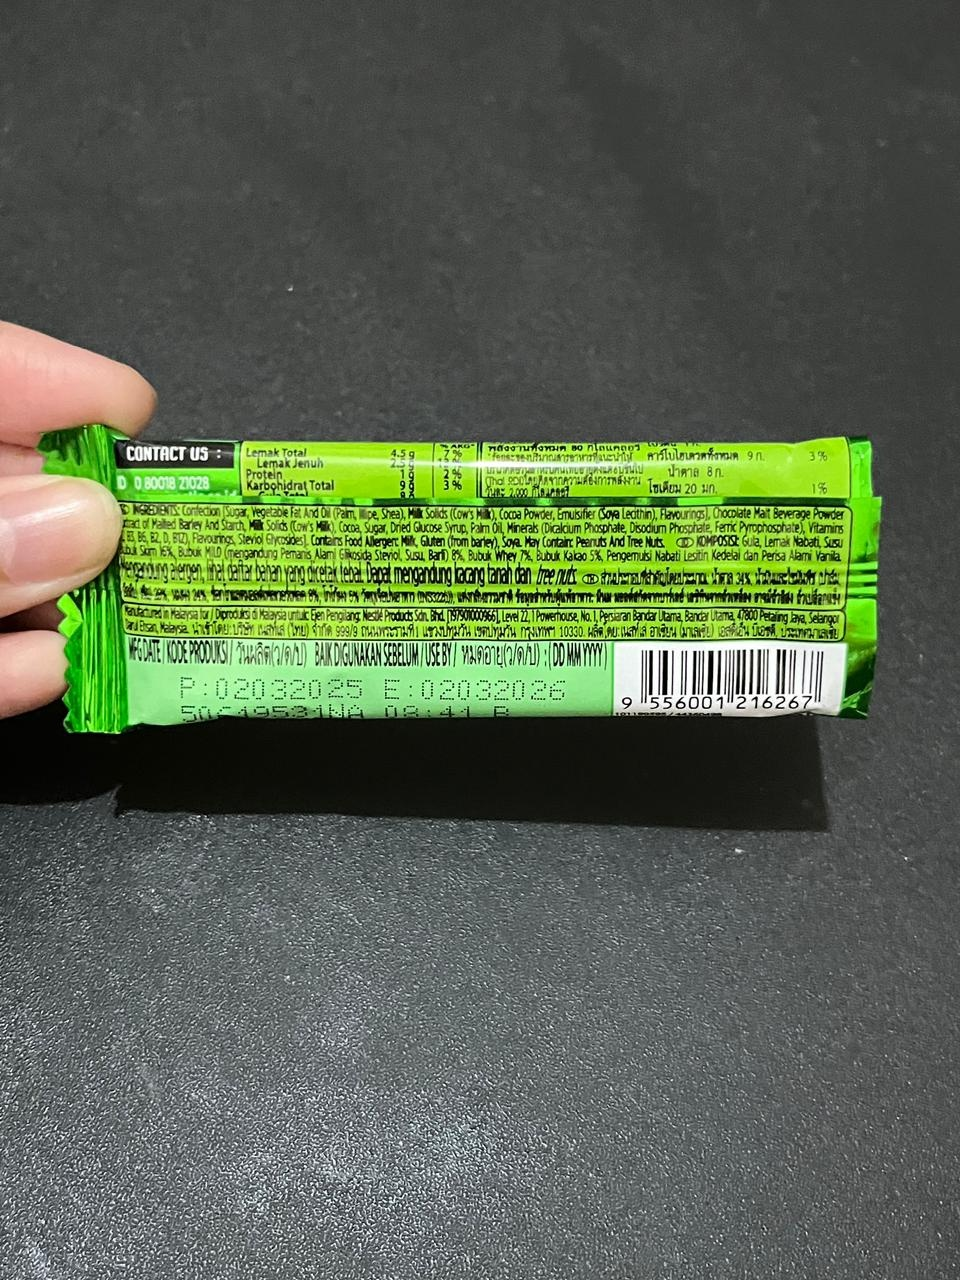

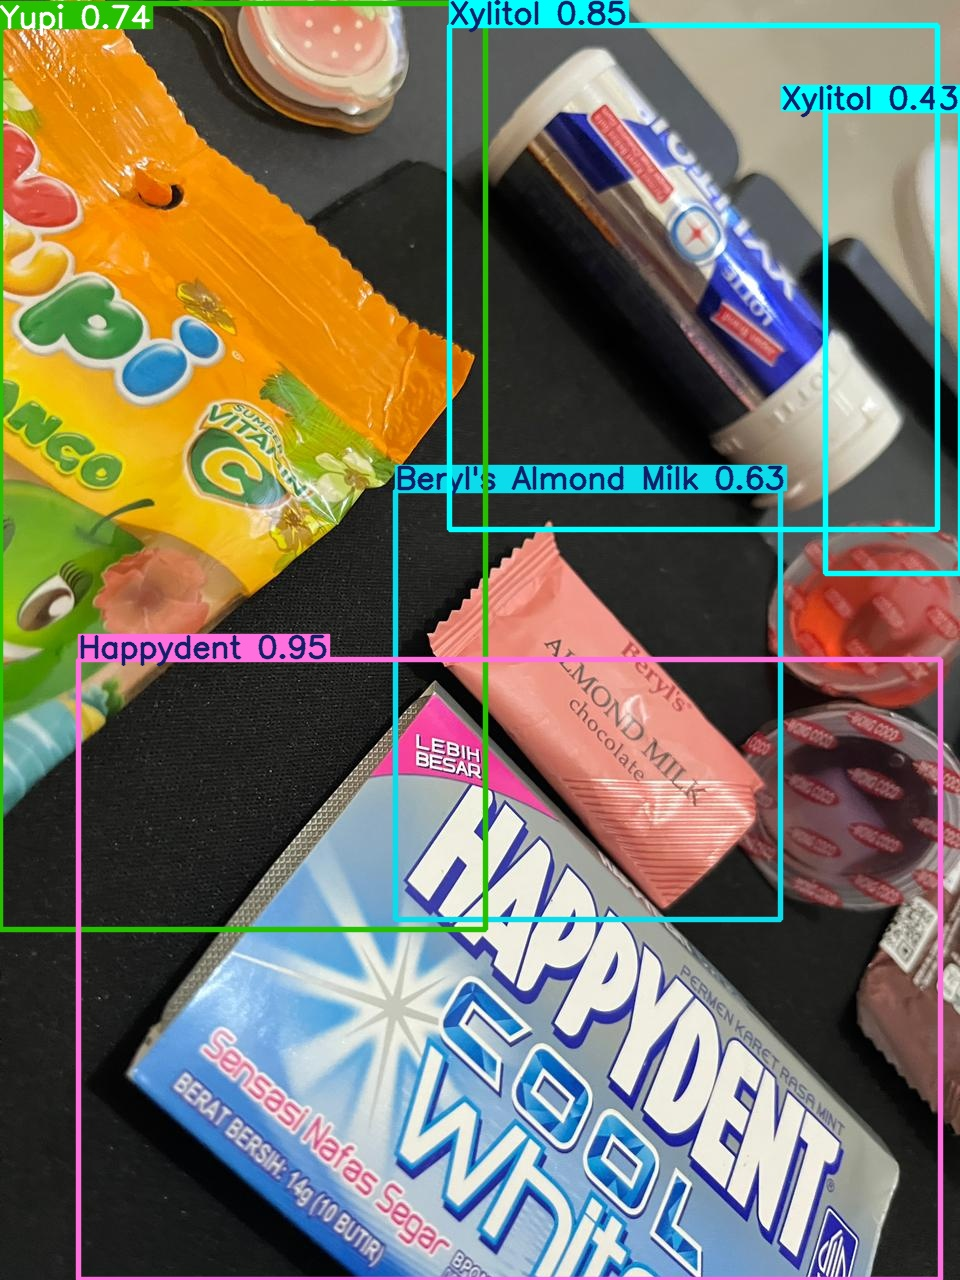

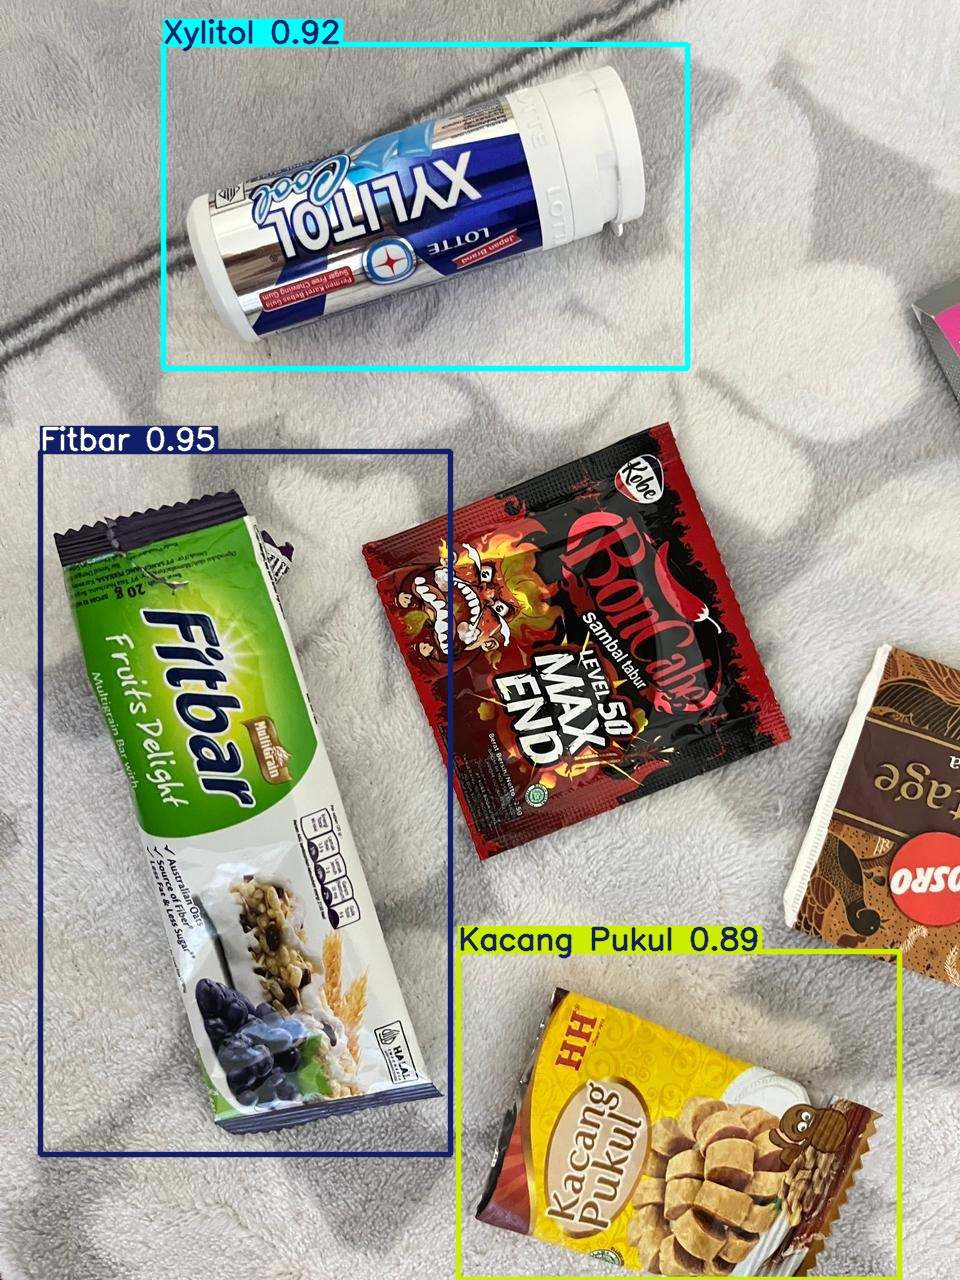

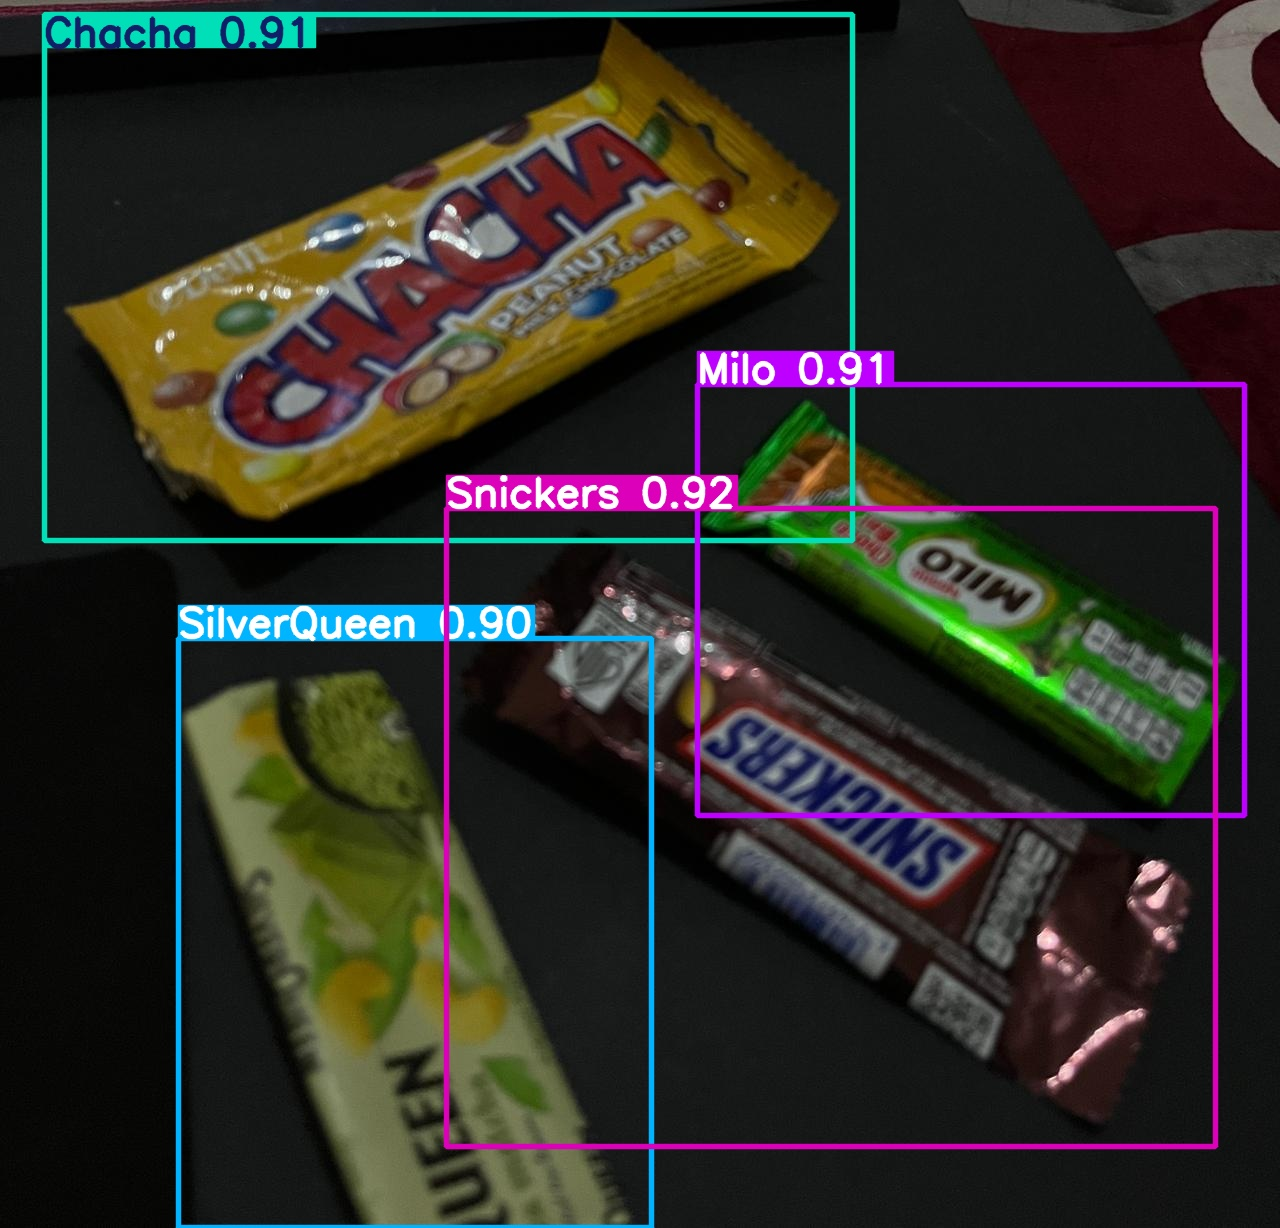

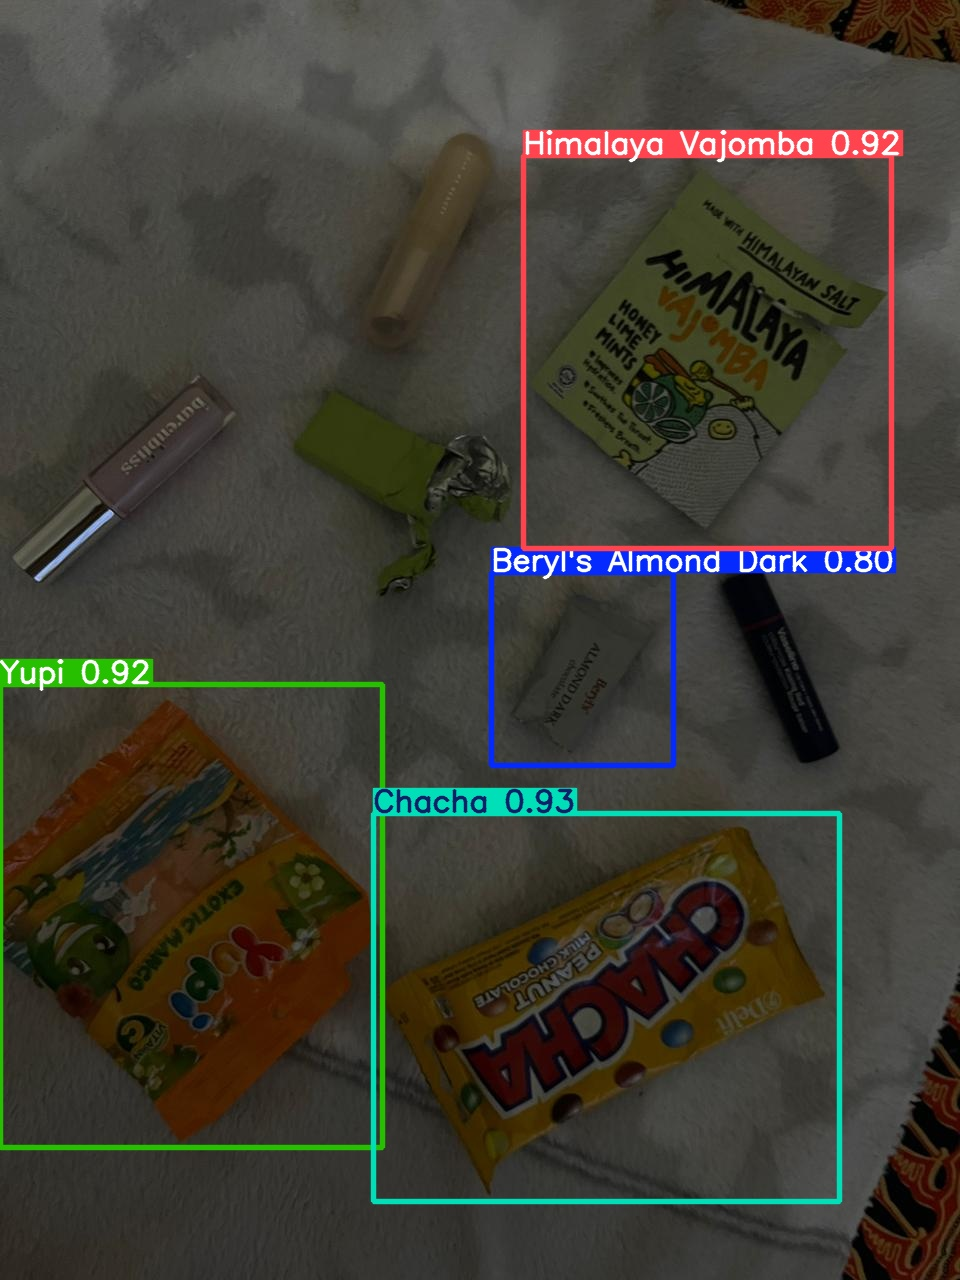

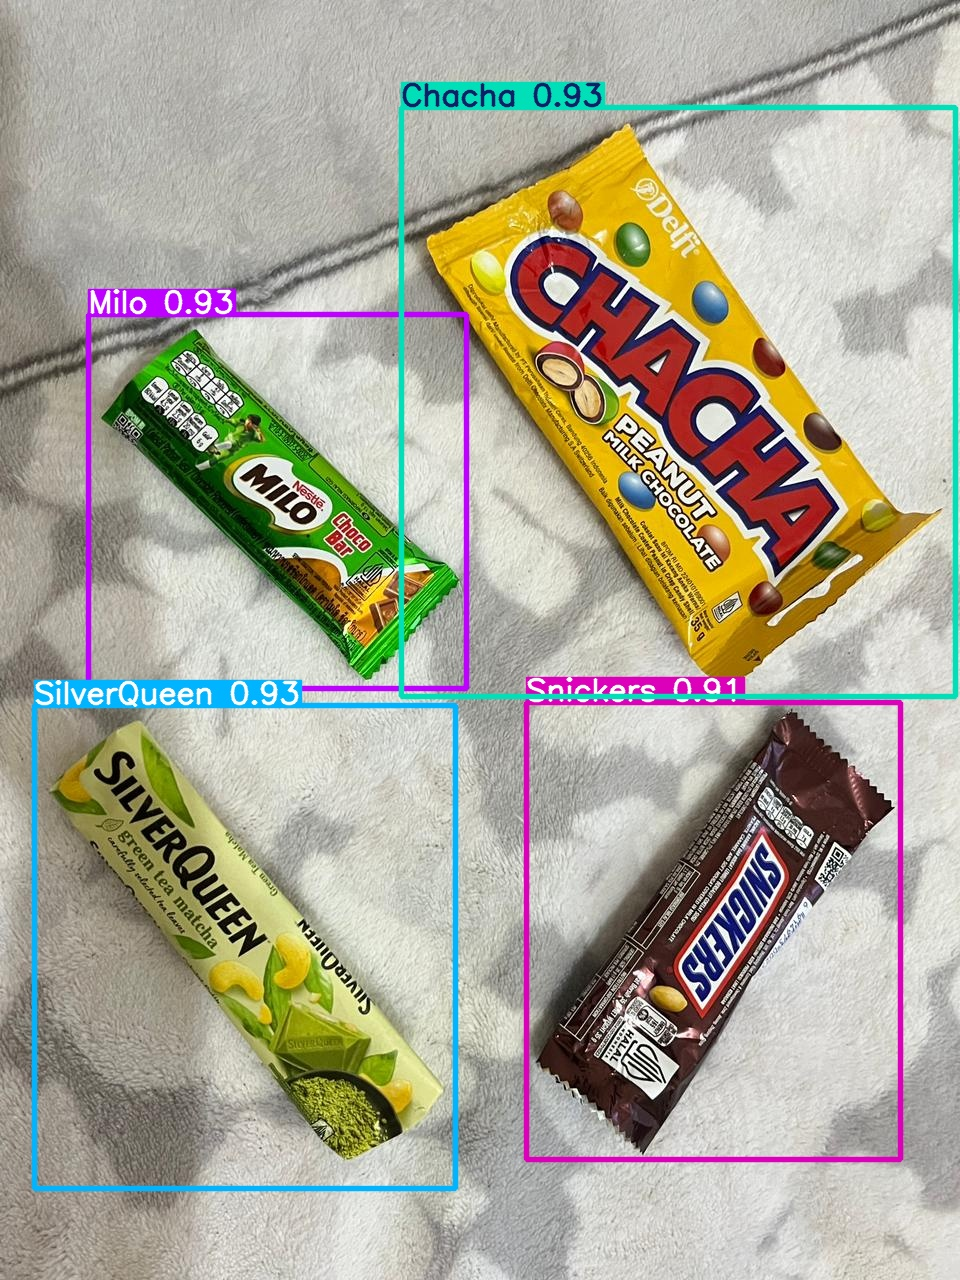

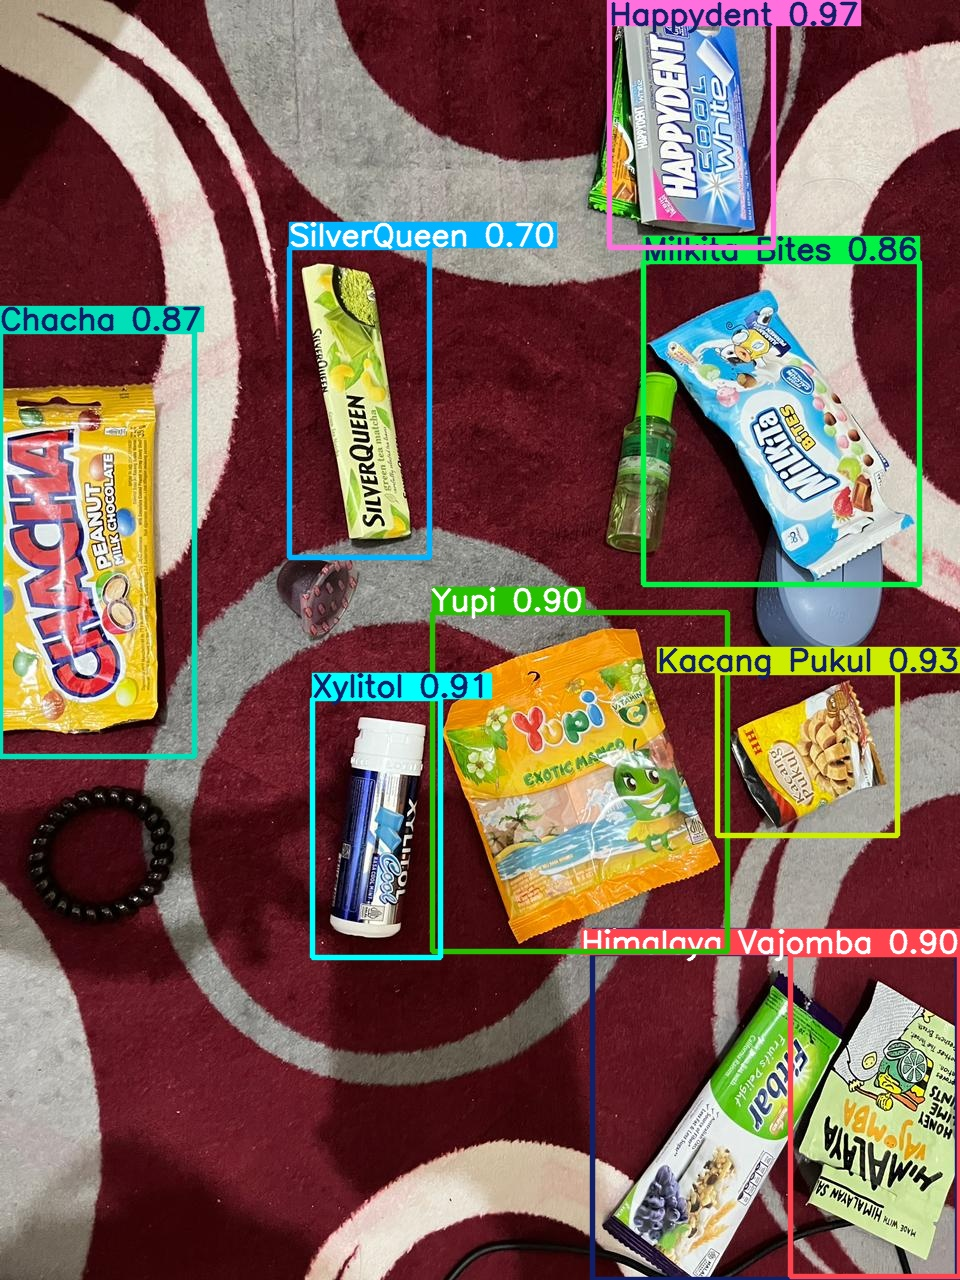

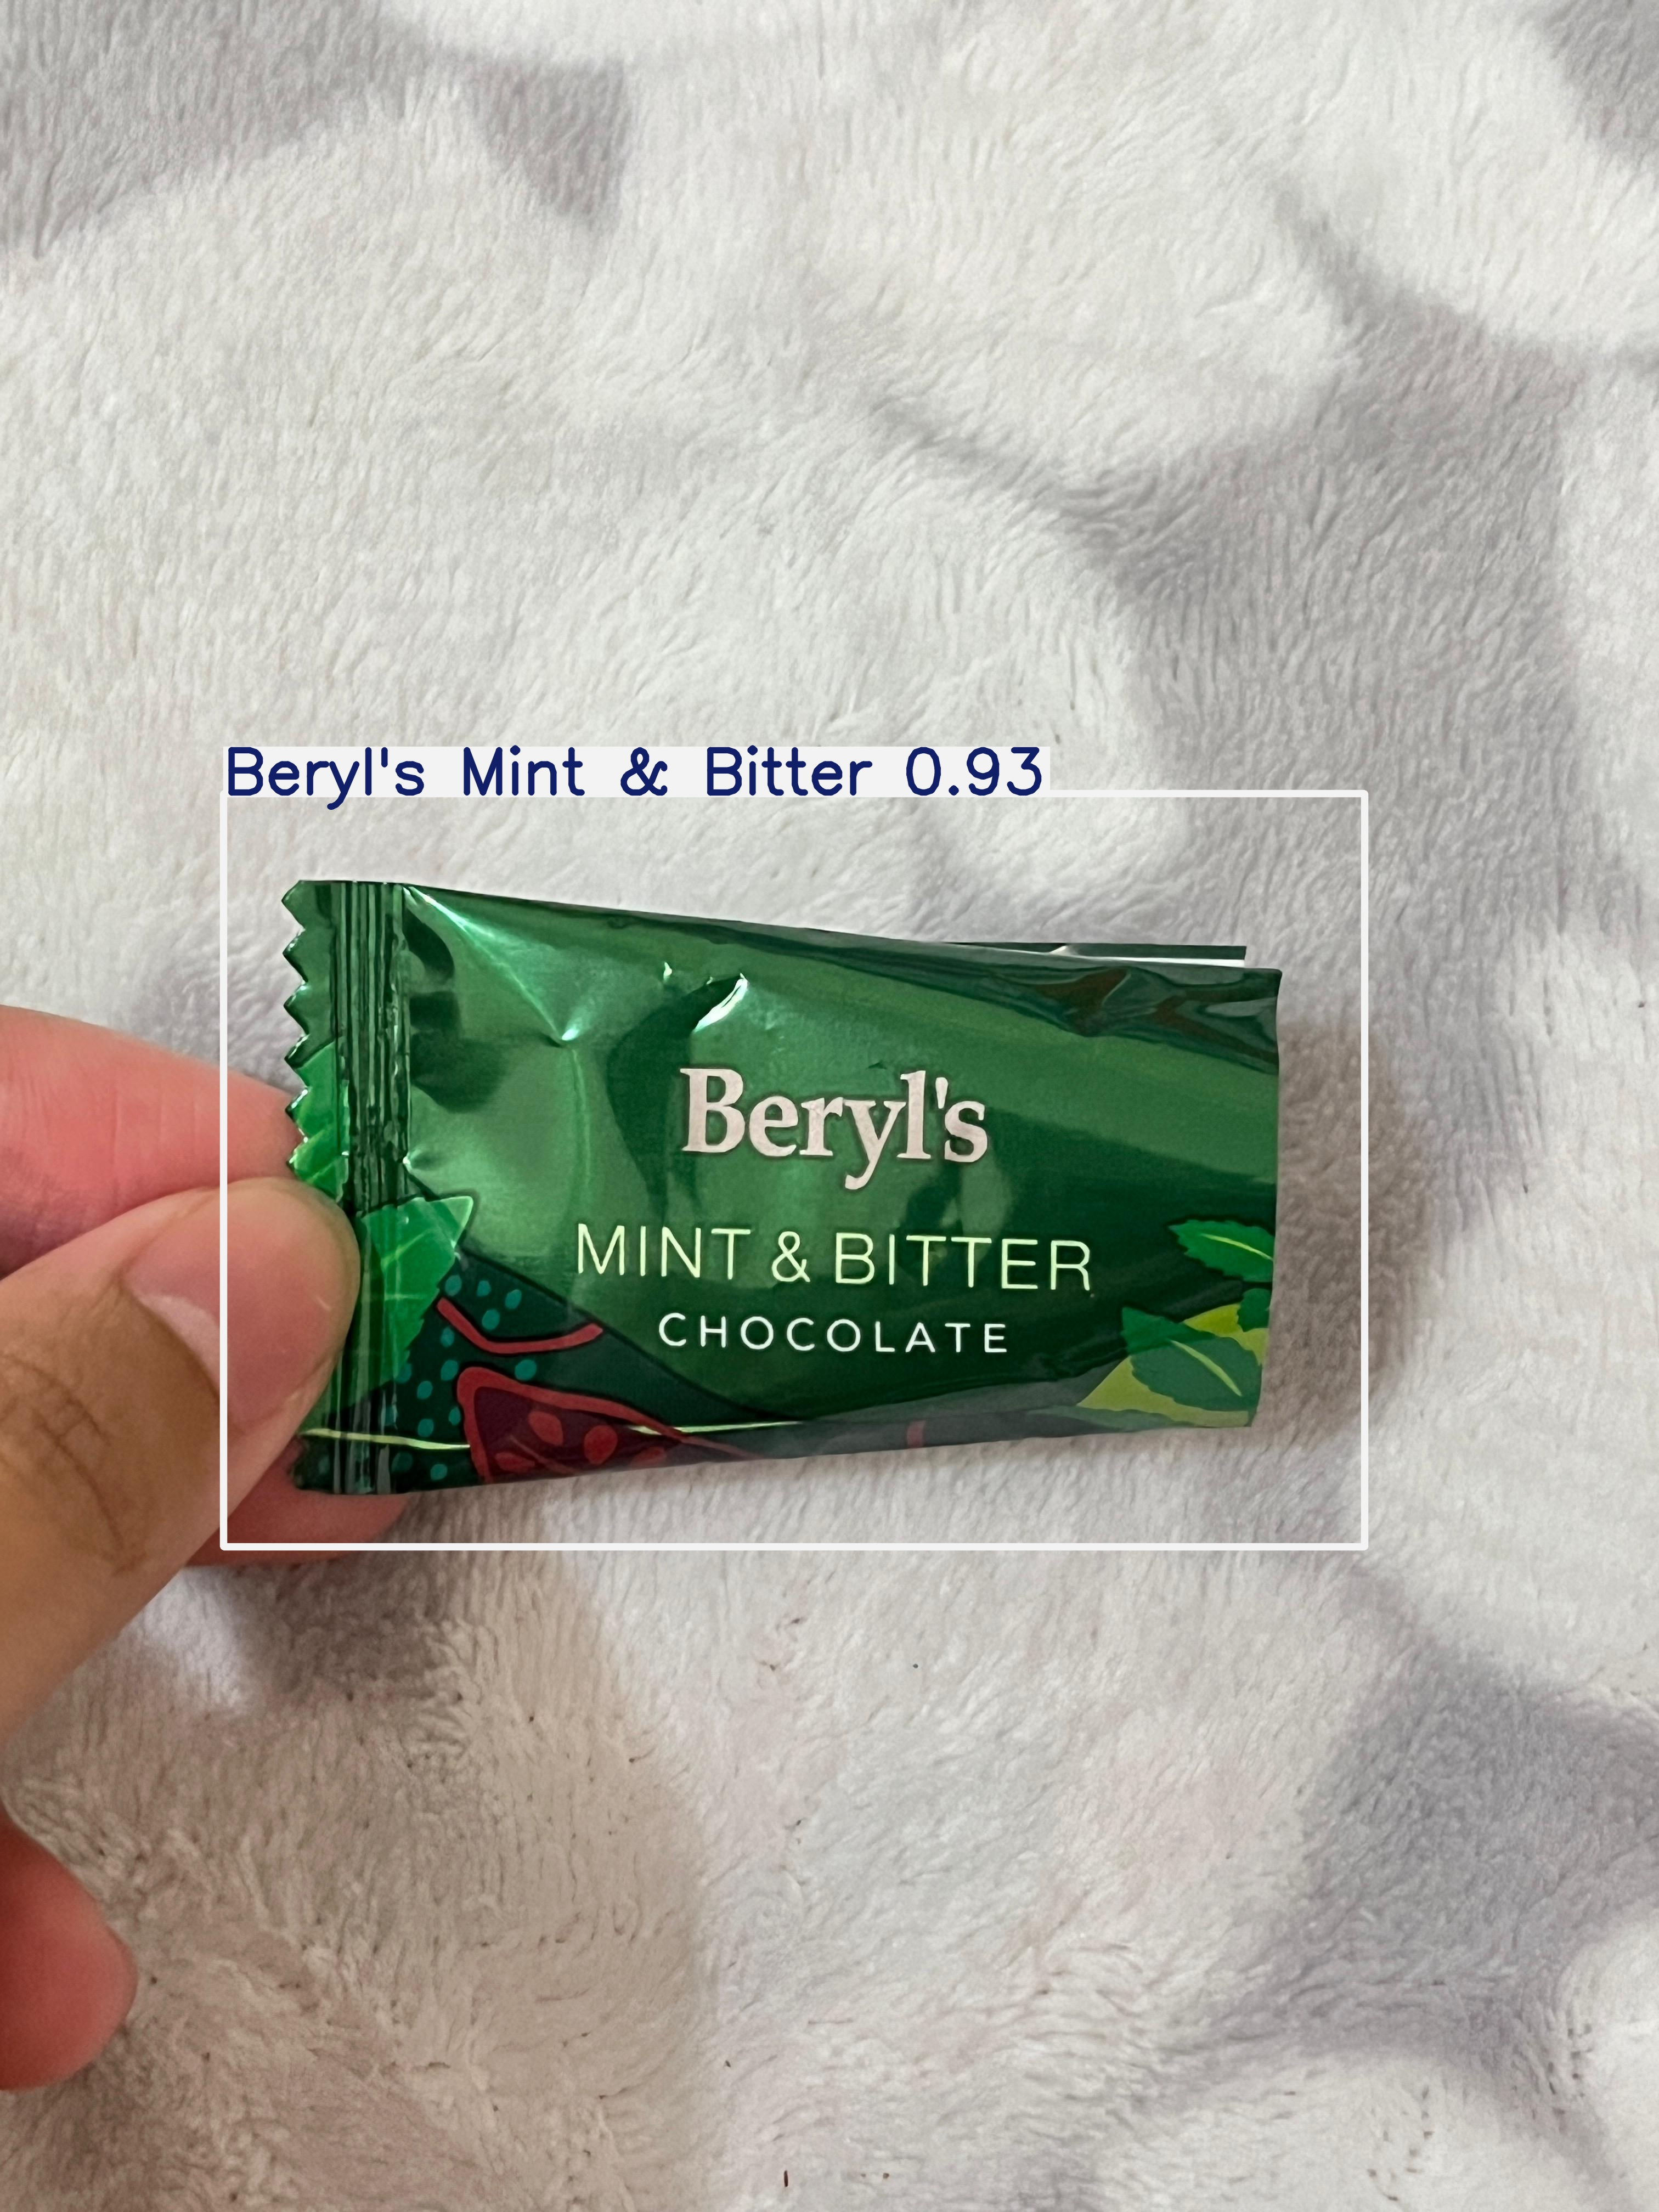

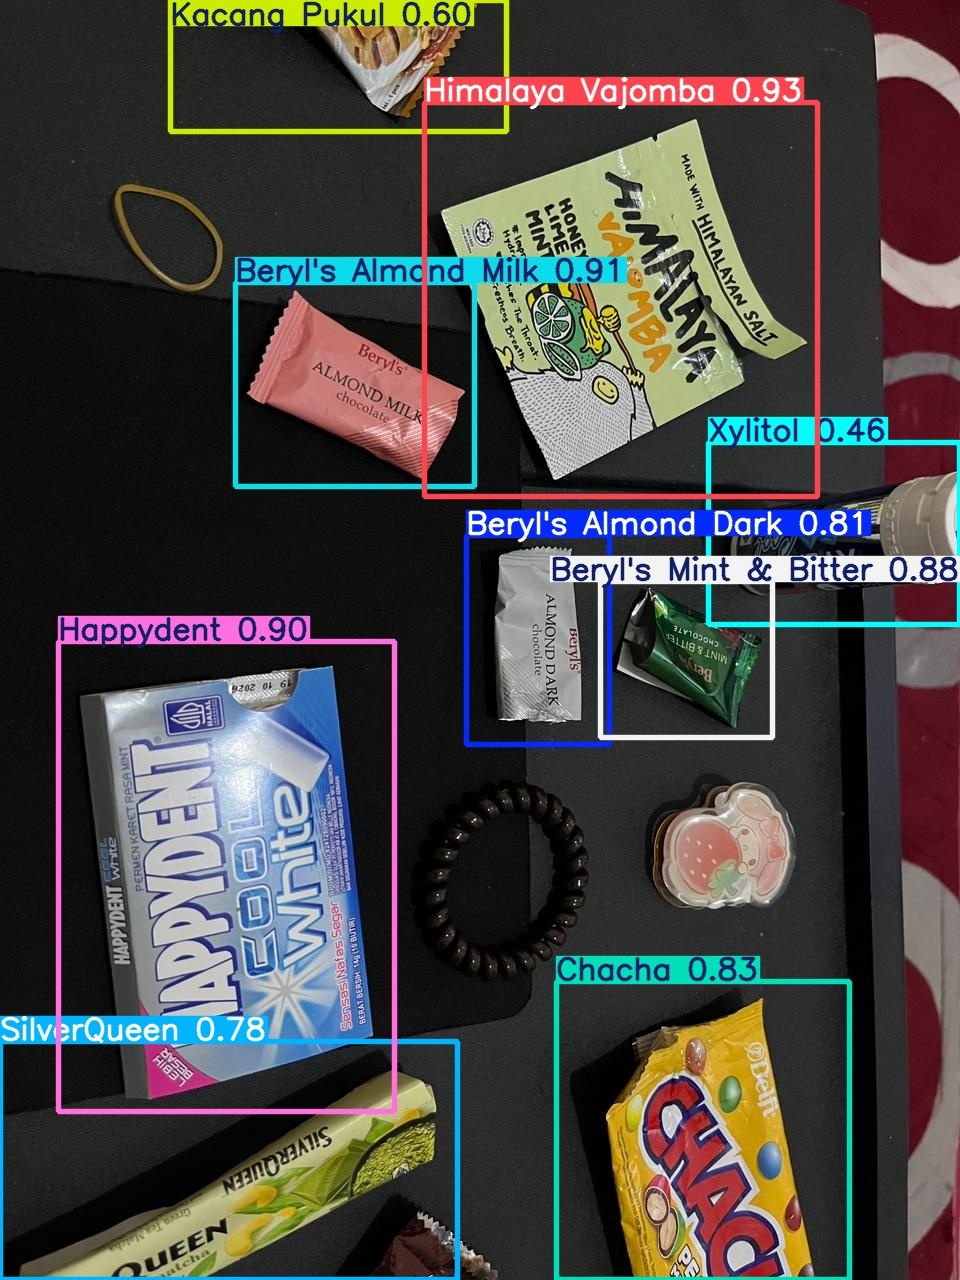

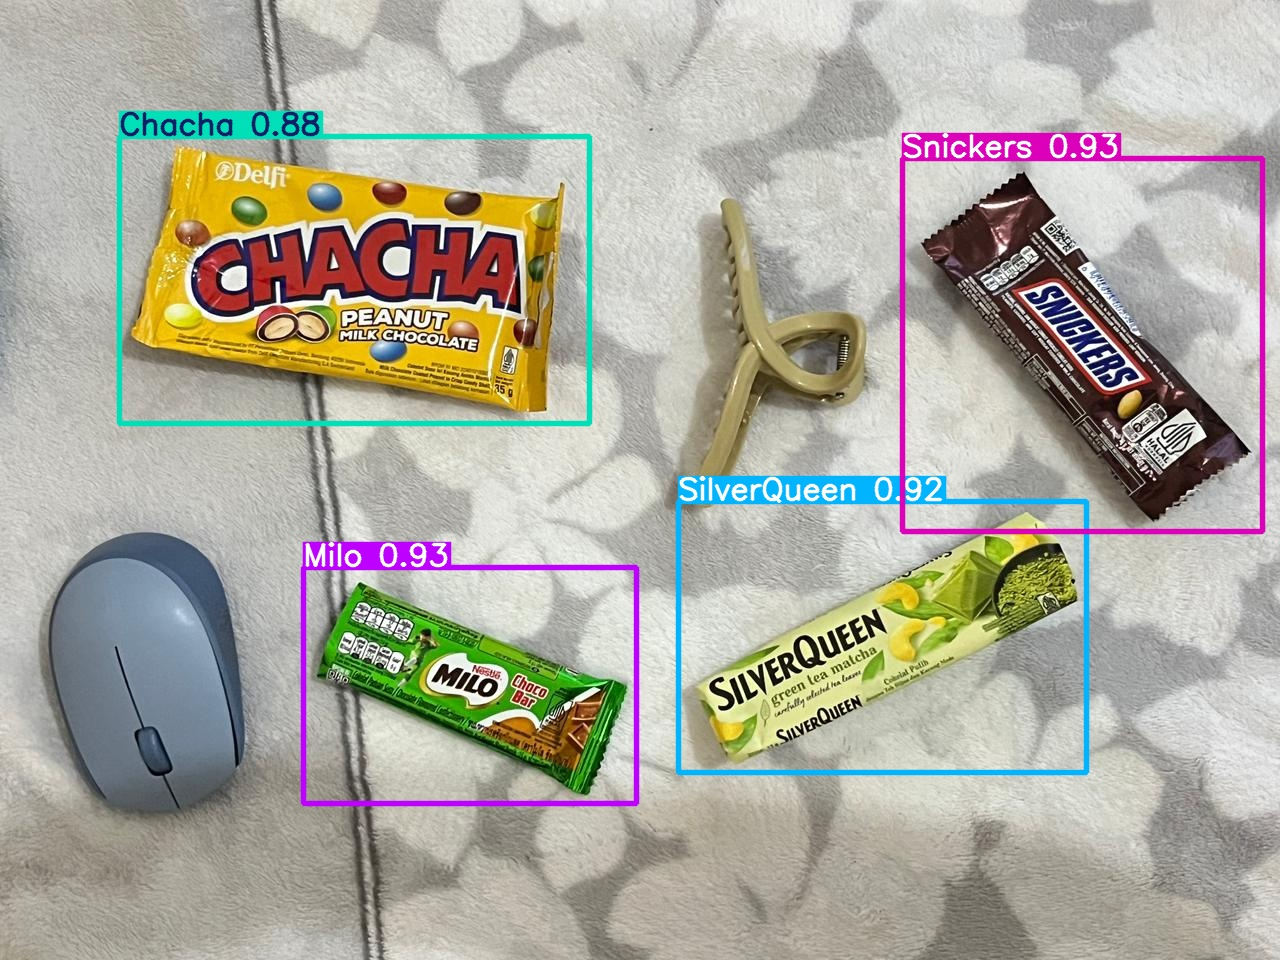

In [9]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

**DEPLOY MODEL - Download YOLO Model**

In [10]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

/content/my_model
  adding: my_model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/P_curve.png (deflated 7%)
  adding: train/confusion_matrix.png (deflated 21%)
  adding: train/val_batch0_labels.jpg (deflated 9%)
  adding: train/train_batch400.jpg (deflated 6%)
  adding: train/R_curve.png (deflated 9%)
  adding: train/train_batch401.jpg (deflated 8%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/F1_curve.png (deflated 5%)
  adding: train/val_batch0_pred.jpg (deflated 9%)
  adding: train/train_batch1.jpg (deflated 2%)
  adding: train/train_batch2.jpg (deflated 3%)
  adding: train/train_batch402.jpg (deflated 9%)
  adding: train/train_batch0.jpg (deflated 2%)
  adding: train/results.csv (deflated 62%)
  adding: train/confusion_matrix_normalized.png (deflated 18%)
  adding: train/results.png (deflated 8%)
  adding: train/args.yaml (deflated 53%)
  adding: train/labels_correlo

In [11]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>